# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Load Data

In [20]:
# update this as needed!

# right now, only looking at tournament seed / performance, not regular season games
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_long = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])

In [22]:
df_leagues.head()

,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [21]:
#UConn = 3163
df_teams.head(10)

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M
5,3106,Alabama St
6,3107,Albany NY
7,3108,Alcorn St
8,3109,Alliant Intl
9,3110,American Univ


In [7]:
# seed = region + seed within region (1-16)
df_seeds.head(10)

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272
5,1998,W06,3438
6,1998,W07,3208
7,1998,W08,3307
8,1998,W09,3304
9,1998,W10,3203


In [8]:
# contains winning and losing team IDs (must check against list of teams)
# winning and losing team scores
# WLoc = home (H), away (A), neutral (N)
df_tour.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1250,2017,145,3199,66,3333,53,N,0
1251,2017,145,3332,77,3268,63,N,0
1252,2017,145,3376,100,3346,58,N,0
1253,2017,146,3280,94,3124,85,N,1
1254,2017,146,3390,76,3323,75,N,0
1255,2017,147,3163,90,3332,52,H,0
1256,2017,147,3376,71,3199,64,N,0
1257,2017,151,3280,66,3163,64,N,1
1258,2017,151,3376,62,3390,53,N,0
1259,2017,153,3376,67,3280,55,N,0


## Merge

In [9]:
df_seeds['NumSeed'] = df_seeds.apply(lambda row: int(row['Seed'][1:3]), axis=1)

In [10]:
## Team Name, Average Seed in Tournament, Number of tournament appearances

df_tourney_hist = df_seeds.groupby('TeamID').agg({'NumSeed' : ['mean','count']}).reset_index()
df_tourney_hist['AvgSeed'] = df_tourney_hist['NumSeed','mean']
df_tourney_hist['NumApps'] = df_tourney_hist['NumSeed','count']
df_tourney_hist.columns = df_tourney_hist.columns.droplevel(level=1)

df_tourney_hist = pd.merge(left=df_tourney_hist[['TeamID','AvgSeed','NumApps']],right=df_teams,how='left',on='TeamID')

df_tourney_hist.head(10)

,TeamID,AvgSeed,NumApps,TeamName
0,3103,13.000000,1,Akron
1,3104,3.500000,2,Alabama
2,3106,15.333333,3,Alabama St
3,3107,14.000000,6,Albany NY
4,3108,16.000000,3,Alcorn St
5,3110,14.000000,2,American Univ
6,3111,16.000000,1,Appalachian St
7,3112,6.833333,6,Arizona
8,3113,6.153846,13,Arizona St
9,3114,12.400000,5,Ark Little Rock


Text(0.5,1,u'Top 15 Teams, Average Tourney Seed')

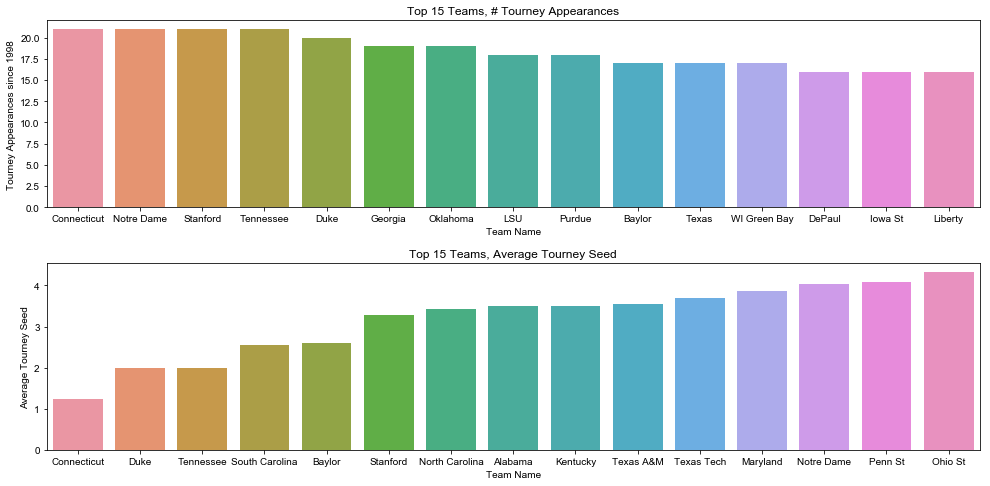

In [11]:
import seaborn as sns

# Set up the figure,axes and style for the plots
fig, axes = plt.subplots(nrows=2,ncols=1, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
fig.set_size_inches(15, 7, forward=True)
sns.set_style("whitegrid")

#df_top_apps = df_tourney_hist.nlargest(15,'NumApps')

# Plot a barplot for Top 15 Tournament winning Teams

ax1 = sns.barplot(x="TeamName", y="NumApps", data=df_tourney_hist.nlargest(15,'NumApps'),ax=axes[0])
ax1.set(xlabel='Team Name', ylabel='Tourney Appearances since 1998')
ax1.set_title('Top 15 Teams, # Tourney Appearances')

ax2 = sns.barplot(x="TeamName", y="AvgSeed", data=df_tourney_hist.nsmallest(15,'AvgSeed'),ax=axes[1])
ax2.set(xlabel='Team Name', ylabel='Average Tourney Seed')
ax2.set_title('Top 15 Teams, Average Tourney Seed')

In [12]:
df_tourney_hist.head()

,TeamID,AvgSeed,NumApps,TeamName
0,3103,13.000000,1,Akron
1,3104,3.500000,2,Alabama
2,3106,15.333333,3,Alabama St
3,3107,14.000000,6,Albany NY
4,3108,16.000000,3,Alcorn St


In [13]:
df_seeds.head()

,Season,Seed,TeamID,NumSeed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3
3,1998,W04,3301,4
4,1998,W05,3272,5


In [14]:
# merge seeds with team IDs for tourney performance
df_merged = pd.merge(left=df_tourney_hist,right=df_seeds, how='left', on='TeamID')

df_W = df_merged.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed','NumSeed':'WNumSeed','TeamName':'WTeamName','AvgSeed':'WAvgSeed','NumApps':'WNumApps'})
df_L = df_merged.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed','NumSeed':'LNumSeed','TeamName':'LTeamName','AvgSeed':'LAvgSeed','NumApps':'LNumApps'})
df_dummy = pd.merge(left=df_tour, right=df_W, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_L, on=['Season', 'LTeamID'])

df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WAvgSeed,WNumApps,WTeamName,WSeed,WNumSeed,LAvgSeed,LNumApps,LTeamName,LSeed,LNumSeed
1250,2017,145,3199,66,3333,53,N,0,5.714286,14,Florida St,Z03,3,4.400000,5,Oregon St,Z02,2
1251,2017,145,3332,77,3268,63,N,0,8.285714,7,Oregon,W10,10,3.866667,15,Maryland,W03,3
1252,2017,145,3376,100,3346,58,N,0,2.555556,9,South Carolina,Z01,1,11.500000,4,Quinnipiac,Z12,12
1253,2017,146,3280,94,3124,85,N,1,5.600000,10,Mississippi St,X02,2,2.588235,17,Baylor,X01,1
1254,2017,146,3390,76,3323,75,N,0,3.285714,21,Stanford,Y02,2,4.047619,21,Notre Dame,Y01,1
1255,2017,147,3163,90,3332,52,H,0,1.238095,21,Connecticut,W01,1,8.285714,7,Oregon,W10,10
1256,2017,147,3376,71,3199,64,N,0,2.555556,9,South Carolina,Z01,1,5.714286,14,Florida St,Z03,3
1257,2017,151,3280,66,3163,64,N,1,5.600000,10,Mississippi St,X02,2,1.238095,21,Connecticut,W01,1
1258,2017,151,3376,62,3390,53,N,0,2.555556,9,South Carolina,Z01,1,3.285714,21,Stanford,Y02,2
1259,2017,153,3376,67,3280,55,N,0,2.555556,9,South Carolina,Z01,1,5.600000,10,Mississippi St,X02,2


In [15]:
# calculate seed differential: positive = higher seed won, negative = lower seed won
df_concat['SeedDiff'] = df_concat.apply(lambda row: row['LNumSeed'] - row['WNumSeed'], axis=1)

df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WAvgSeed,WNumApps,WTeamName,WSeed,WNumSeed,LAvgSeed,LNumApps,LTeamName,LSeed,LNumSeed,SeedDiff
1250,2017,145,3199,66,3333,53,N,0,5.714286,14,Florida St,Z03,3,4.400000,5,Oregon St,Z02,2,-1
1251,2017,145,3332,77,3268,63,N,0,8.285714,7,Oregon,W10,10,3.866667,15,Maryland,W03,3,-7
1252,2017,145,3376,100,3346,58,N,0,2.555556,9,South Carolina,Z01,1,11.500000,4,Quinnipiac,Z12,12,11
1253,2017,146,3280,94,3124,85,N,1,5.600000,10,Mississippi St,X02,2,2.588235,17,Baylor,X01,1,-1
1254,2017,146,3390,76,3323,75,N,0,3.285714,21,Stanford,Y02,2,4.047619,21,Notre Dame,Y01,1,-1
1255,2017,147,3163,90,3332,52,H,0,1.238095,21,Connecticut,W01,1,8.285714,7,Oregon,W10,10,9
1256,2017,147,3376,71,3199,64,N,0,2.555556,9,South Carolina,Z01,1,5.714286,14,Florida St,Z03,3,2
1257,2017,151,3280,66,3163,64,N,1,5.600000,10,Mississippi St,X02,2,1.238095,21,Connecticut,W01,1,-1
1258,2017,151,3376,62,3390,53,N,0,2.555556,9,South Carolina,Z01,1,3.285714,21,Stanford,Y02,2,1
1259,2017,153,3376,67,3280,55,N,0,2.555556,9,South Carolina,Z01,1,5.600000,10,Mississippi St,X02,2,1


## Previous Appearances

Indicate a team's previous experience in tournaments. The number of games played will be a proxy for this (more games played = more appearances and also better performance when they appear). 

Worth noting is also the win percentage, as appearing every year and never winning (for example) doesn't necessarily indicate success, either.

In [16]:
df_tour_hist = df_concat
df_tour_hist.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WAvgSeed,WNumApps,WTeamName,WSeed,WNumSeed,LAvgSeed,LNumApps,LTeamName,LSeed,LNumSeed,SeedDiff
0,1998,137,3104,94,3422,46,H,0,3.500000,2,Alabama,X02,2,15.000000,1,UNC Greensboro,X15,15,13
1,1998,137,3112,75,3365,63,H,0,6.833333,6,Arizona,W03,3,13.250000,4,Santa Clara,W14,14,11
2,1998,137,3163,93,3193,52,H,0,1.238095,21,Connecticut,W02,2,13.500000,2,Fairfield,W15,15,13
3,1998,137,3198,59,3266,45,H,0,7.000000,3,Florida Intl,Y07,7,7.625000,8,Marquette,Y10,10,3
4,1998,137,3203,74,3208,72,A,0,7.833333,12,G Washington,W10,10,5.315789,19,Georgia,W07,7,-3


In [25]:
#
winning_games_w = df_tour_hist.groupby('WTeamID').count().reset_index()[['WTeamID','Season']].rename(columns={'Season':'WWins'})
winning_games_l = df_tour_hist.groupby('WTeamID').count().reset_index()[['WTeamID','Season']].rename(columns={'Season':'LWins','WTeamID':'LTeamID'})

losing_games_w = df_concat.groupby('LTeamID').count().reset_index()[['LTeamID','Season']].rename(columns={'Season':'WLosses','LTeamID':'WTeamID'})
losing_games_l = df_concat.groupby('LTeamID').count().reset_index()[['LTeamID','Season']].rename(columns={'Season':'LLosses'})

# get total tournament games - all games, could be more than 1 appearance per year
df_total_apps = pd.merge(left=df_tour_hist, right=winning_games_w, how='left', on=['WTeamID']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=winning_games_l, how='left', on=['LTeamID']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_w, how='left', on=['WTeamID']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_l, how='left', on=['LTeamID']).fillna(0)


df_total_apps['WTotGames'] = df_total_apps['WWins'] + df_total_apps['WLosses']
df_total_apps['WPctWins'] = df_total_apps['WWins'] / df_total_apps['WTotGames'] 

df_total_apps['LTotGames'] = df_total_apps['LWins'] + df_total_apps['LLosses']
df_total_apps['LPctWins'] = df_total_apps['LWins'] / df_total_apps['LTotGames'] 

# This now includes: 
df_total_apps.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WAvgSeed,WNumApps,...,LNumSeed,SeedDiff,WWins,LWins,WLosses,LLosses,WTotGames,WPctWins,LTotGames,LPctWins
0,1998,137,3104,94,3422,46,H,0,3.500000,2,...,15,13,3,0.0,2,1,5,0.600000,1.0,0.0
1,1998,137,3112,75,3365,63,H,0,6.833333,6,...,14,11,5,0.0,6,4,11,0.454545,4.0,0.0
2,1998,137,3163,93,3193,52,H,0,1.238095,21,...,15,13,93,0.0,10,2,103,0.902913,2.0,0.0
3,1998,137,3198,59,3266,45,H,0,7.000000,3,...,10,3,2,3.0,3,7,5,0.400000,10.0,0.3
4,1998,137,3203,74,3208,72,A,0,7.833333,12,...,7,-3,9,27.0,11,18,20,0.450000,45.0,0.6


(array([ 10.,   2.,   5.,   6.,   8.,   9.,   8.,   6.,   5.,   1.]),
 array([ 0.        ,  0.09029126,  0.18058252,  0.27087379,  0.36116505,
         0.45145631,  0.54174757,  0.63203883,  0.7223301 ,  0.81262136,
         0.90291262]),
 <a list of 10 Patch objects>)

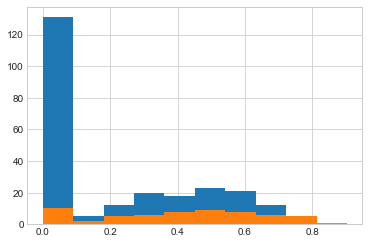

In [27]:
## What teams have good win percentages
df_win_apps = df_total_apps.rename(columns={'WTeamName':'TeamName','WPctWins' : 'PctWins','WTeamID' : 'TeamID', 'WTotGames': 'TotGames'})
df_loss_apps = df_total_apps.rename(columns={'LTeamName':'TeamName','LPctWins' : 'PctWins', 'LTeamID' : 'TeamID', 'LTotGames': 'TotGames'})

df_apps = df_win_apps[['TeamName','PctWins','TeamID','TotGames']].append(df_loss_apps[['TeamName','PctWins','TeamID','TotGames']])
df_apps = df_apps.drop_duplicates()
#df_apps.head()
#plt.bar(df_apps['TeamName'],df_apps['PctWins'])

## This means that a lot of these have never been to the tournament - makes sense

plt.hist(df_apps['PctWins'],bins=10)

# Maybe need to filter for just teams that are currently in tourney
l = df_seeds.loc[df_seeds['Season'] == 2018]
plt.hist((df_apps[df_apps['TeamID'].isin(l['TeamID'])])['PctWins'],bins=10)

In [ ]:
# Set up the figure,axes and style for the plots
fig, axes = plt.subplots(nrows=2,ncols=1, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
fig.set_size_inches(15, 7, forward=True)
sns.set_style("whitegrid")

# Plot a barplot for Top 15 Tournament winning Teams

ax1 = sns.barplot(x="TeamName", y="PctWins", data=df_apps.nlargest(15,'PctWins'),ax=axes[0])
ax1.set(xlabel='Team Name', ylabel='Tourney Win Percentage since 1998')
ax1.set_title('Top 15 Teams, Win Percentage in Tournaments since 1998')

# shows what type of history (good or bad) a team has in the tournament
ax2 = sns.barplot(x="TeamName", y="TotGames", data=df_apps.nlargest(15,'TotGames'),ax=axes[1])
ax2.set(xlabel='Team Name', ylabel='Tournament Games since 1998')
ax2.set_title('Top 15 Teams, Total Number of Tournament Games')

In [56]:
# Merge Performance Stats with league info
df_league_pct = pd.merge(left=df_apps, right = df_leagues, how='left', on=['TeamID','TeamName'])
#df_league_pct.head()

# group by league to see how leagues perform
df_league_perf = df_league_pct.groupby('LeagueName').agg({'PctWins' : ['mean','count']}).reset_index()
df_league_perf

LeagueName   PctWins      
                       mean count
0             AAC  0.244191    12
1             ACC  0.546656    14
2            ASUN  0.050000     4
3    America East  0.168571     5
4     Atlantic 10  0.266138     9
5          Big 12  0.538906    10
6        Big East  0.387647     8
7         Big Sky  0.000000     8
8       Big South  0.023529     5
9         Big Ten  0.442750    14
10       Big West  0.044643     7
11          C-USA  0.298990    11
12            CAA  0.114286     5
13        Horizon  0.101010     6
14     Ivy League  0.068571     5
15           MAAC  0.091667     8
16            MAC  0.071429    11
17           MEAC  0.000000     8
18            MVC  0.105769     6
19            MWC  0.173882     7
20            NEC  0.000000     5
21            OVC  0.000000     8
22         Pac-12  0.539678    11
23        Patriot  0.000000     8
24            SEC  0.591840    14
25           SWAC  0.000000     7
26          SoCon  0.011905     6
27      Southland  0.028571     5
28  Summit League  0.044444     5
29       Sun Belt  0.047619     7
30            WAC  0.000000     1
31            WCC  0.152099     8

# Predict

In [ ]:
df_wins = pd.DataFrame()
df_wins[['SeedDiff','WProb']] = total_apps[['SeedDiff','WPctWins']]
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -total_apps['SeedDiff']
df_losses['WProb'] = total_apps['LPctWins']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.tail()

In [138]:
## Create training and test data sets; may create a dev dataset later
num_test = len(df_predictions)

# TODO: Add dev data!
mask = np.random.rand(len(df_predictions)) < 0.7 ## 80% data for training and 20% for testing
train_data = df_predictions[mask]
test_data = df_predictions[~mask]
mask = np.random.rand(len(test_data)) < 0.5
dev_data = test_data[mask]
test_data = test_data[~mask]


In [139]:
## Convert to arrays
#X_train = train_data.SeedDiff.values.reshape(-1,1)
#y_train = train_data.Result.values
X_train = train_data.drop(['Result'],axis=1).as_matrix()
y_train = train_data['Result'].values

X_dev = dev_data.drop(['Result'],axis=1).as_matrix()
y_dev = dev_data['Result'].values
X_test = test_data.SeedDiff.values.reshape(-1,1)
y_test = test_data.Result.values
print X_train[:10]

[[ 13.           0.6       ]
 [ 11.           0.45454545]
 [ 13.           0.90291262]
 [ -3.           0.45      ]
 [  9.           0.38095238]
 [ -1.           0.41176471]
 [ -1.           0.72857143]
 [ 15.           0.5       ]
 [ 15.           0.61538462]
 [  3.           0.54545455]]


In [140]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='f1', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

clf.score(X_dev,y_dev)
#clf.score(X_train,y_train)

Best log_loss: 0.7855, with best C: 1.0


0.75000000000000011

In [114]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

[[-10]
 [ -9]
 [ -8]
 [ -7]
 [ -6]
 [ -5]
 [ -4]
 [ -3]
 [ -2]
 [ -1]
 [  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]]


ValueError: X has 1 features per sample; expecting 2

In [115]:
df_sample_sub = pd.read_csv('WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))


In [116]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label


In [117]:
## Unpack the ID field for team IDs
## Look up seeds for the team
## Calculate seed difference

X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [36]:
## Make predictions

preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head(10)

,ID,Pred
0,2014_3103_3107,0.376260
1,2014_3103_3113,0.739968
2,2014_3103_3119,0.502908
3,2014_3103_3124,0.945607
4,2014_3103_3140,0.567136
5,2014_3103_3143,0.826767
6,2014_3103_3151,0.629184
7,2014_3103_3163,0.950000
8,2014_3103_3169,0.317780
9,2014_3103_3173,0.860737


In [38]:
df_sample_sub.to_csv('test-submission.csv', index=False)